## Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP)

Мы долго работали и построили модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.

Таким образом, Вам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN.

Исходные файлы:

* data.csv — данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт)
* model.csv — результаты прогнозирования дефолта (PD), полученные в нашей разработанной модели
* sample_submission.csv — пример файла, который необходимо отправить

Результаты решения прикрепите в CSV формате. Файл должен содержать только прогнозные значения |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN, в одном столбце без заголовка. В качестве оценки решения будет использоваться характеристика MAE.

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore") 

In [2]:
# данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, 
# представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт)
data = pd.read_csv('data.csv', index_col=False)
data

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.143840,0.259385,0.547065,0.287680,0.287680,0,1,1,1,20184
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82612,20559842,NaN,2020-01,1.0,2,34,2.0,2.0,3,0,...,NaN,0.358156,0.301572,0.187271,NaN,0,0,0,1,20201
82613,20380255,NaN,2020-01,10.0,2,66,2.0,0.0,5,1,...,0.116099,0.391072,0.391072,0.391072,0.391072,0,0,0,0,20201
82614,20348581,NaN,2020-01,4.0,1,32,1.0,0.0,3,0,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20201
82615,21118162,NaN,2020-02,5.0,2,62,5.0,0.0,6,1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,20201


Рассмотрим таргет: видим что 1000 значений пустые - их нам нужно предсказать.

In [3]:
data.flg_90_12_add.value_counts(dropna=False)

0.0    77585
1.0     4032
NaN     1000
Name: flg_90_12_add, dtype: int64

In [4]:
# результаты прогнозирования дефолта (PD), полученные в разработанной модели
model = pd.read_csv('model.csv', index_col=False)
model

,incident,PD
0,14511110,0.022191
1,15018800,0.019972
2,14499737,0.043884
3,14953427,0.013412
4,14744453,0.033354
...,...,...
82612,20559842,NaN
82613,20380255,NaN
82614,20348581,NaN
82615,21118162,NaN


Объединим файлы и получим таргет, который требуется предсказать по условию задачи:

In [5]:
df = data.merge(model, on='incident')
df['target'] = np.abs(df.PD - data.flg_90_12_add)
df

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,PD,target
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,NaN,0,0,0,1,20184,0.022191,0.022191
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.547065,0.287680,0.287680,0,1,1,1,20184,0.019972,0.019972
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,0.242687,NaN,NaN,0,1,0,1,20184,0.043884,0.043884
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,NaN,0,1,1,1,20184,0.013412,0.013412
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,NaN,NaN,NaN,0,1,0,1,20184,0.033354,0.033354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82612,20559842,NaN,2020-01,1.0,2,34,2.0,2.0,3,0,...,0.301572,0.187271,NaN,0,0,0,1,20201,NaN,NaN
82613,20380255,NaN,2020-01,10.0,2,66,2.0,0.0,5,1,...,0.391072,0.391072,0.391072,0,0,0,0,20201,NaN,NaN
82614,20348581,NaN,2020-01,4.0,1,32,1.0,0.0,3,0,...,NaN,NaN,NaN,0,1,1,1,20201,NaN,NaN
82615,21118162,NaN,2020-02,5.0,2,62,5.0,0.0,6,1,...,NaN,NaN,NaN,0,0,0,0,20201,NaN,NaN


Посмотрим как распределен таргет: видим, что есть "хвост" распределения.

Прологарифмируем таргет - теперь вид распределния больше похож на нормальный.

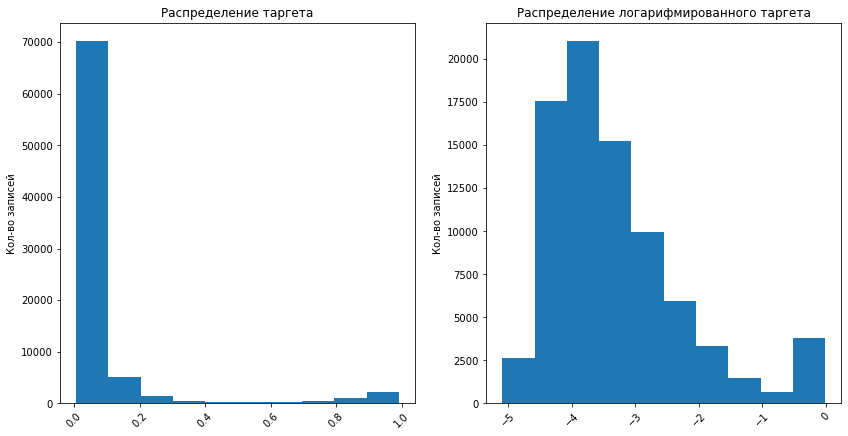

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist(df['target'])
ax[0].set_title("Распределение таргета")
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel("Кол-во записей")

ax[1].hist(np.log(df['target']))
ax[1].set_title("Распределение логарифмированного таргета")
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel("Кол-во записей")
plt.show()

In [7]:
df['log_target'] = np.log(df['target'])

Замечаем фичи, где довольно много пропусков. Удалим их из датасета:

In [8]:
# если в feature больше, чем 70% пропущенных данных - удалим ее

columns_for_drop = []

for column in df.columns:
    if column != 'flg_90_12_add' and df[column].isna().sum() >= 0.7 * len(df):
        columns_for_drop.append(column)
        
clear_data = df.drop(columns_for_drop, axis=1)
clear_data

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1879,Feature_1880,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,PD,target,log_target
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,0,0,0,1,20184,0.022191,0.022191,-3.808085
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.259385,0.547065,0,1,1,1,20184,0.019972,0.019972,-3.913427
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,0.420321,0.242687,0,1,0,1,20184,0.043884,0.043884,-3.126204
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,0,1,1,1,20184,0.013412,0.013412,-4.311604
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,0.045863,NaN,0,1,0,1,20184,0.033354,0.033354,-3.400582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82612,20559842,NaN,2020-01,1.0,2,34,2.0,2.0,3,0,...,0.358156,0.301572,0,0,0,1,20201,NaN,NaN,NaN
82613,20380255,NaN,2020-01,10.0,2,66,2.0,0.0,5,1,...,0.391072,0.391072,0,0,0,0,20201,NaN,NaN,NaN
82614,20348581,NaN,2020-01,4.0,1,32,1.0,0.0,3,0,...,NaN,NaN,0,1,1,1,20201,NaN,NaN,NaN
82615,21118162,NaN,2020-02,5.0,2,62,5.0,0.0,6,1,...,NaN,NaN,0,0,0,0,20201,NaN,NaN,NaN


Остальные фичи, содержащие пропущенные значения, постараемся заполнить:
* категориальные фичи - наиболее часто встречающимся значением
* численные фичи - средним

In [9]:
features = clear_data.loc[:, 'Feature_0':'Feature_1887']
for col in features:
    if clear_data[col].isna().sum():
        clear_data[col] = clear_data[col].fillna(clear_data.groupby('APPLICATION_MONTH')[col].transform('mean'))

category_features = clear_data.loc[:, 'Category_Feature_0':'Category_Feature_18']
for col in category_features:
    if clear_data[col].isna().sum():
        clear_data[col] = clear_data[col].fillna(clear_data.groupby('APPLICATION_MONTH')[col].transform(lambda x: 
                                                                                                    x.mode().iat[0]))

Удалим фичи, которые не нужны для модели:

In [10]:
clear_data.drop(['incident', 'flg_90_12_add', 'APPLICATION_MONTH', 'PD'], axis=1, inplace=True)

Разделим данные на train/test:

In [11]:
train = clear_data[:81617]
test = clear_data[81617:].reset_index(drop=True)

X = train.drop(['log_target', 'target'], axis=1)
y = train[['log_target', 'target']]

Для того чтобы посмотреть важность фичей для модели, натренируем модель:

In [12]:
model = CatBoostRegressor(loss_function='MAE', random_seed=42, silent=True)
model.fit(X, y['log_target'])

In [13]:
values = model.get_feature_importance()
importance = pd.DataFrame(X.columns, columns=['feature'])
importance['values'] = values
importance.sort_values(by='values', ascending=False, inplace=True)
importance

,feature,values
2,Category_Feature_2,10.073022
1,Category_Feature_1,8.155714
415,Feature_960,6.743126
417,Feature_962,5.153773
701,Feature_1884,3.189840
...,...,...
599,Feature_1577,0.000000
83,Feature_64,0.000000
594,Feature_1563,0.000000
593,Feature_1560,0.000000


Видим, что есть фичи, importance которых равен 0. Удалим их и получим новые train/test данные:

In [14]:
importance[importance['values'] == 0]

,feature,values
24,Feature_5,0.0
9,Category_Feature_9,0.0
276,Feature_618,0.0
264,Feature_598,0.0
267,Feature_603,0.0
...,...,...
599,Feature_1577,0.0
83,Feature_64,0.0
594,Feature_1563,0.0
593,Feature_1560,0.0


In [15]:
columns_for_drop = importance[importance['values'] == 0]['feature'].values
        
clear_data = clear_data.drop(columns_for_drop, axis=1)

Заметим, что наибольшее влияние оказывают Category_Feature_2 и Category_Feature_1. Построим их распределения:

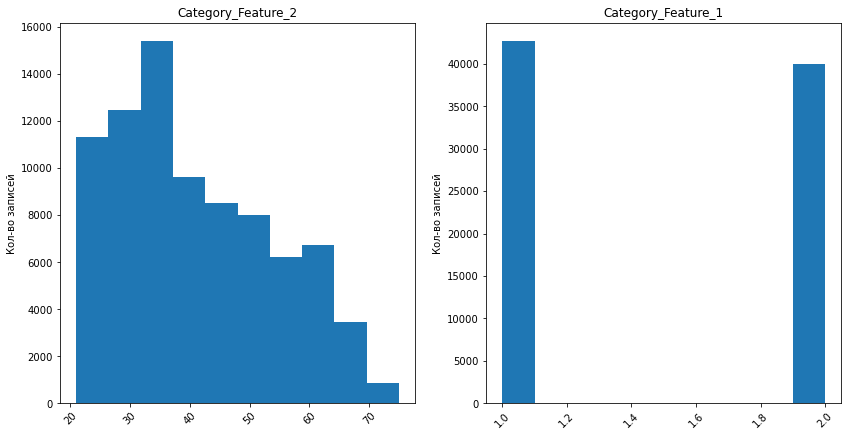

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist(clear_data['Category_Feature_2'])
ax[0].set_title("Category_Feature_2")
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel("Кол-во записей")

ax[1].hist(clear_data['Category_Feature_1'])
ax[1].set_title("Category_Feature_1")
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel("Кол-во записей")
plt.show()

Сложно понять что означает Category_Feature_1, но Category_Feature_2, видимо, обозначает возраст.

Логарифмируем ее, чтобы получить распределение, вид которого более похож на нормальное:

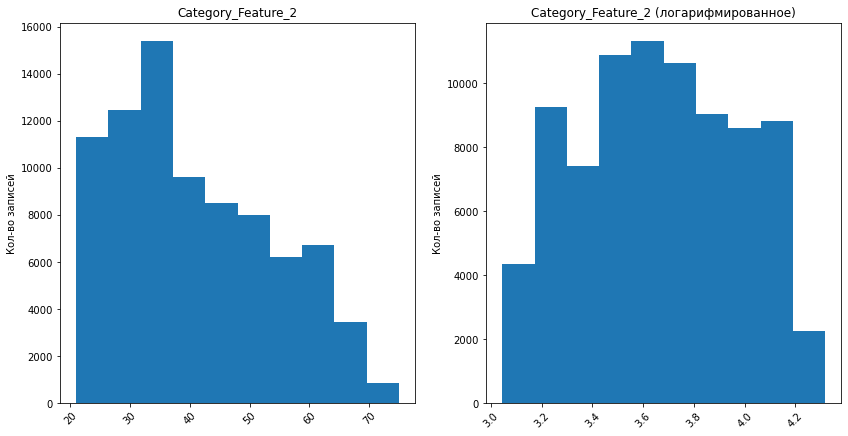

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].hist(clear_data['Category_Feature_2'])
ax[0].set_title("Category_Feature_2")
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel("Кол-во записей")

clear_data['log_Category_Feature_2'] = np.log(clear_data['Category_Feature_2'])
ax[1].hist(clear_data['log_Category_Feature_2'])
ax[1].set_title("Category_Feature_2 (логарифмированное)")
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel("Кол-во записей")
plt.show()

Удалим ненужную фичу.

Теперь снова разделим данные на train/test, а затем train датасет разделим допольнительно на обучающуюся и валидационную выборку.

С помощью grid search подберем оптимальные гиперпараметры для модели CatBoostRegressor.

In [18]:
clear_data.drop('Category_Feature_2', axis=1, inplace=True)

train = clear_data[:81617]
test = clear_data[81617:].reset_index(drop=True)

X = train.drop(['log_target', 'target'], axis=1)
y = train[['log_target', 'target']]

X_train_val, X_val, y_train_val, y_val = train_test_split(X, y, test_size=0.3)

In [19]:
y_train_val

,log_target,target
43642,-4.221697,0.014674
52904,-2.545964,0.078397
63027,-3.495353,0.030338
62637,-4.376998,0.012563
60012,-4.459911,0.011563
...,...,...
3606,-3.598927,0.027353
52660,-4.242909,0.014366
2124,-3.135130,0.043494
52403,-3.388874,0.033747


In [20]:
grid = {'learning_rate': [0.001, 0.03, 0.1],
        'depth': [4, 6, 9],
        'l2_leaf_reg': [1, 5, 9]}

model = CatBoostRegressor(iterations=500, loss_function='MAE', random_seed=42, silent=True)
grid_search_result = model.grid_search(grid, 
                                       X=X_train_val, 
                                       y=y_train_val['log_target'])


bestTest = 2.031930048
bestIteration = 499

0:	loss: 2.0319300	best: 2.0319300 (0)	total: 8.83s	remaining: 3m 49s

bestTest = 0.5066920781
bestIteration = 499

1:	loss: 0.5066921	best: 0.5066921 (1)	total: 18.4s	remaining: 3m 50s

bestTest = 0.4988856755
bestIteration = 495

2:	loss: 0.4988857	best: 0.4988857 (2)	total: 27.7s	remaining: 3m 41s

bestTest = 2.031934238
bestIteration = 499

3:	loss: 2.0319342	best: 0.4988857 (2)	total: 36.8s	remaining: 3m 31s

bestTest = 0.506528448
bestIteration = 499

4:	loss: 0.5065284	best: 0.4988857 (2)	total: 46.4s	remaining: 3m 24s

bestTest = 0.4979091536
bestIteration = 499

5:	loss: 0.4979092	best: 0.4979092 (5)	total: 55.5s	remaining: 3m 14s

bestTest = 2.031944993
bestIteration = 499

6:	loss: 2.0319450	best: 0.4979092 (5)	total: 1m 4s	remaining: 3m 3s

bestTest = 0.5062085311
bestIteration = 499

7:	loss: 0.5062085	best: 0.4979092 (5)	total: 1m 13s	remaining: 2m 54s

bestTest = 0.4986637022
bestIteration = 498

8:	loss: 0.4986637	best: 0.497

Самый оптимальный набор гиперпараметров:

In [21]:
model.get_params()

{'iterations': 500,
 'loss_function': 'MAE',
 'random_seed': 42,
 'silent': True,
 'depth': 6,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1}

Спрогнозируем результат и посчитаем метрику MAE на валидационной выборке:

In [22]:
cat_boost = CatBoostRegressor(iterations=2000, learning_rate=0.1, 
                          depth=6, 
                          l2_leaf_reg=9, 
                          loss_function='MAE', 
                          random_seed=42, 
                          silent=True)
cat_boost.fit(X_train_val, y_train_val['log_target'])
res = cat_boost.predict(X_val)
print(f"MAE = {mean_absolute_error(np.exp(res), y_val['target'])}")

MAE = 0.058669198100357055


Получим результат для тестовой выборки:

In [23]:
cat_boost = CatBoostRegressor(iterations=2000, learning_rate=0.1, 
                          depth=6, 
                          l2_leaf_reg=9, 
                          loss_function='MAE', 
                          random_seed=42, 
                          silent=True)
cat_boost.fit(X, y['log_target'])
res = cat_boost.predict(test)
res = np.exp(res)

In [24]:
pd.DataFrame(res, columns=['result']).to_csv('result.csv', index=False)